In [1]:
## requirements
# conda install --file env/byoml_tensorflow/environment.yml
# conda activate byoml_tensorflow 
# pip install -r env/byoml_tensorflow/requirements.txt

In [2]:
MODEL_NAME='retries-example'
WINDOW=12
TEST_DATA_SIZE = 24
PROFILE='demo'
from waylay import __version__
__version__

'v0.7.0'

## Retries example based on a TensorFlow model

In this notebook we show how you can create and upload a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).
When a model is uploaded to Waylay, it takes a moment to compile the model. After compilation, the model will be available for use. If a request ('get' or 'predict') is done before the model is compiled, a 409 Error will be returned. Python SDK has a standard Retry policy, but this can be configured by the user as they wish. If logging is turned on, more info on each retry will be logged.

First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd
import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger('waylay').setLevel(logging.INFO)

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

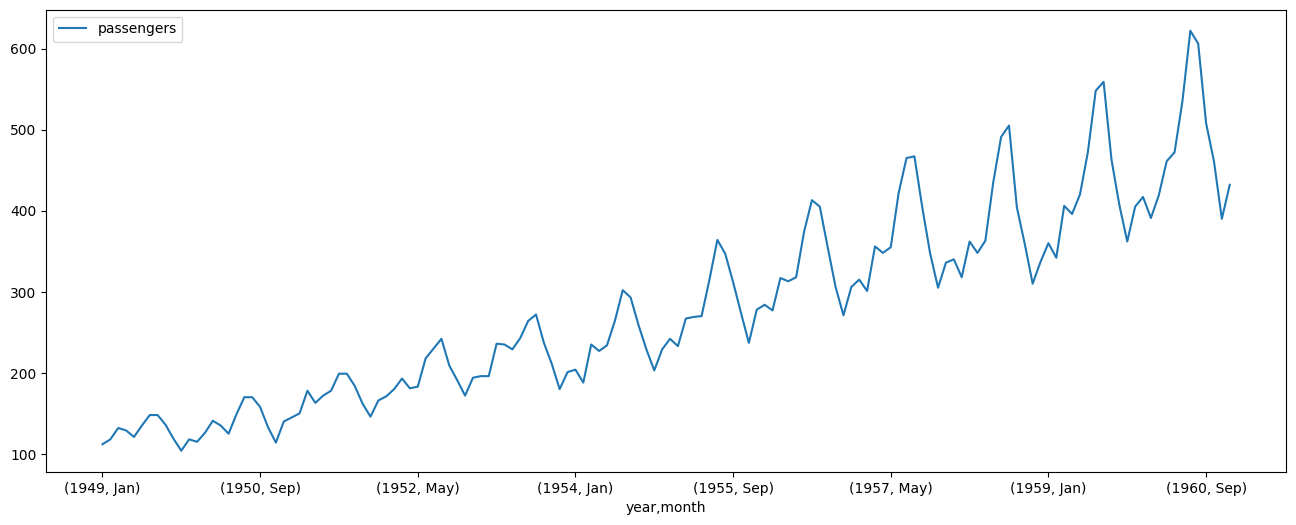

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

In [5]:
import tensorflow as tf
import numpy as np

In [6]:


# features are a sliding window over the last 12 months, predicting the following month
def features_and_labels(input_df, window=WINDOW):
    feat_columns = [ f'+{i}M' for i in range(window) ]
    label_columns = [f'+{window}M']
    index = input_df.index[:len(input_df.index) - window]
    
    ds = tf.data.Dataset.from_tensor_slices(input_df['passengers'].values)
    feat_ds = ds.window(window, shift=1, drop_remainder=True).take(len(index))
    
    df_feat = pd.DataFrame(
        data=(list(w.as_numpy_iterator()) for w in feat_ds), 
        index=index, 
        columns=feat_columns
    )

    df_labels = pd.DataFrame(
        data=input_df.iloc[window:,0].values, 
        index=index, 
        columns=label_columns
    )
    
    return pd.concat([df_feat, df_labels], axis=1, keys=['features','labels'])

df_train = features_and_labels(df.iloc[:-TEST_DATA_SIZE])
display(df_train)
df_test = features_and_labels(df.iloc[-TEST_DATA_SIZE-WINDOW:])

2023-10-16 15:52:19.109929: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


features                                                         \
                +0M  +1M  +2M  +3M  +4M  +5M  +6M  +7M  +8M  +9M +10M +11M   
year month                                                                   
1949 Jan        112  118  132  129  121  135  148  148  136  119  104  118   
     Feb        118  132  129  121  135  148  148  136  119  104  118  115   
     Mar        132  129  121  135  148  148  136  119  104  118  115  126   
     Apr        129  121  135  148  148  136  119  104  118  115  126  141   
     May        121  135  148  148  136  119  104  118  115  126  141  135   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1957 Aug        467  404  347  305  336  340  318  362  348  363  435  491   
     Sep        404  347  305  336  340  318  362  348  363  435  491  505   
     Oct        347  305  336  340  318  362  348  363  435  491  505  404   
     Nov        305  336  340  318  362  348  363  435  491  505  404  359   
     Dec        336  340  318  362  348  363  435  491  505  404  359  310   

           labels  
             +12M  
year month         
1949 Jan      115  
     Feb      126  
     Mar      141  
     Apr      135  
     May      125  
...           ...  
1957 Aug      505  
     Sep      404  
     Oct      359  
     Nov      310  
     Dec      337  

[108 rows x 13 columns]

In [7]:
X_train = tf.convert_to_tensor(df_train.xs('features',axis=1).values)
y_train = tf.convert_to_tensor(df_train.xs('labels',axis=1).values)
X_test = tf.convert_to_tensor(df_test.xs('features',axis=1).values)
y_test = tf.convert_to_tensor(df_test.xs('labels',axis=1).values)

Now we can create the model, a simple one:

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],), name="previous_month"))
model.add(tf.keras.layers.Reshape((X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [9]:
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=1000,
                    verbose=1)

Epoch 1/1000
27/27 [==============================] - 1s 2ms/step - loss: 74600.4297
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 73640.0938
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 72105.3828
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 69885.5703
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 68061.1328
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 66394.4688
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: 65032.1992
Epoch 8/1000
27/27 [==============================] - 0s 2ms/step - loss: 63816.4258
Epoch 9/1000
27/27 [==============================] - 0s 2ms/step - loss: 62678.1250
Epoch 10/1000
27/27 [==============================] - 0s 2ms/step - loss: 61587.0820
Epoch 11/1000
27/27 [==============================] - 0s 2ms/step - loss: 60565.3906
Epoch 12/1000
27/27 [==============================] - 0s 2ms/s

27/27 [==============================] - 0s 2ms/step - loss: 174.3618
Epoch 575/1000
27/27 [==============================] - 0s 2ms/step - loss: 186.6048
Epoch 576/1000
27/27 [==============================] - 0s 2ms/step - loss: 178.8148
Epoch 577/1000
27/27 [==============================] - 0s 2ms/step - loss: 167.4612
Epoch 578/1000
27/27 [==============================] - 0s 2ms/step - loss: 131.8260
Epoch 579/1000
27/27 [==============================] - 0s 2ms/step - loss: 153.8291
Epoch 580/1000
27/27 [==============================] - 0s 2ms/step - loss: 134.3463
Epoch 581/1000
27/27 [==============================] - 0s 2ms/step - loss: 178.8382
Epoch 582/1000
27/27 [==============================] - 0s 2ms/step - loss: 130.3376
Epoch 583/1000
27/27 [==============================] - 0s 2ms/step - loss: 125.1709
Epoch 584/1000
27/27 [==============================] - 0s 2ms/step - loss: 122.3656
Epoch 585/1000
27/27 [==============================] - 0s 2ms/step - loss: 113.

27/27 [==============================] - 0s 2ms/step - loss: 32.4423
Epoch 768/1000
27/27 [==============================] - 0s 2ms/step - loss: 31.4711
Epoch 769/1000
27/27 [==============================] - 0s 2ms/step - loss: 37.3597
Epoch 770/1000
27/27 [==============================] - 0s 2ms/step - loss: 58.4804
Epoch 771/1000
27/27 [==============================] - 0s 2ms/step - loss: 92.4063
Epoch 772/1000
27/27 [==============================] - 0s 2ms/step - loss: 92.6866
Epoch 773/1000
27/27 [==============================] - 0s 2ms/step - loss: 62.0016
Epoch 774/1000
27/27 [==============================] - 0s 2ms/step - loss: 77.3089
Epoch 775/1000
27/27 [==============================] - 0s 2ms/step - loss: 88.5449
Epoch 776/1000
27/27 [==============================] - 0s 2ms/step - loss: 71.5490
Epoch 777/1000
27/27 [==============================] - 0s 2ms/step - loss: 69.1978
Epoch 778/1000
27/27 [==============================] - 0s 2ms/step - loss: 52.9234
Epoch 7

27/27 [==============================] - 0s 2ms/step - loss: 193.3640
Epoch 962/1000
27/27 [==============================] - 0s 2ms/step - loss: 102.5822
Epoch 963/1000
27/27 [==============================] - 0s 2ms/step - loss: 97.6331
Epoch 964/1000
27/27 [==============================] - 0s 2ms/step - loss: 59.6883
Epoch 965/1000
27/27 [==============================] - 0s 3ms/step - loss: 53.2740
Epoch 966/1000
27/27 [==============================] - 0s 2ms/step - loss: 104.4276
Epoch 967/1000
27/27 [==============================] - 0s 2ms/step - loss: 312.7682
Epoch 968/1000
27/27 [==============================] - 0s 2ms/step - loss: 214.1424
Epoch 969/1000
27/27 [==============================] - 0s 3ms/step - loss: 144.6955
Epoch 970/1000
27/27 [==============================] - 0s 2ms/step - loss: 173.2145
Epoch 971/1000
27/27 [==============================] - 0s 3ms/step - loss: 154.4492
Epoch 972/1000
27/27 [==============================] - 0s 2ms/step - loss: 106.913

Let's validate if the model learned something:

4/4 [==============================] - 0s 2ms/step


<Axes: xlabel='year,month'>

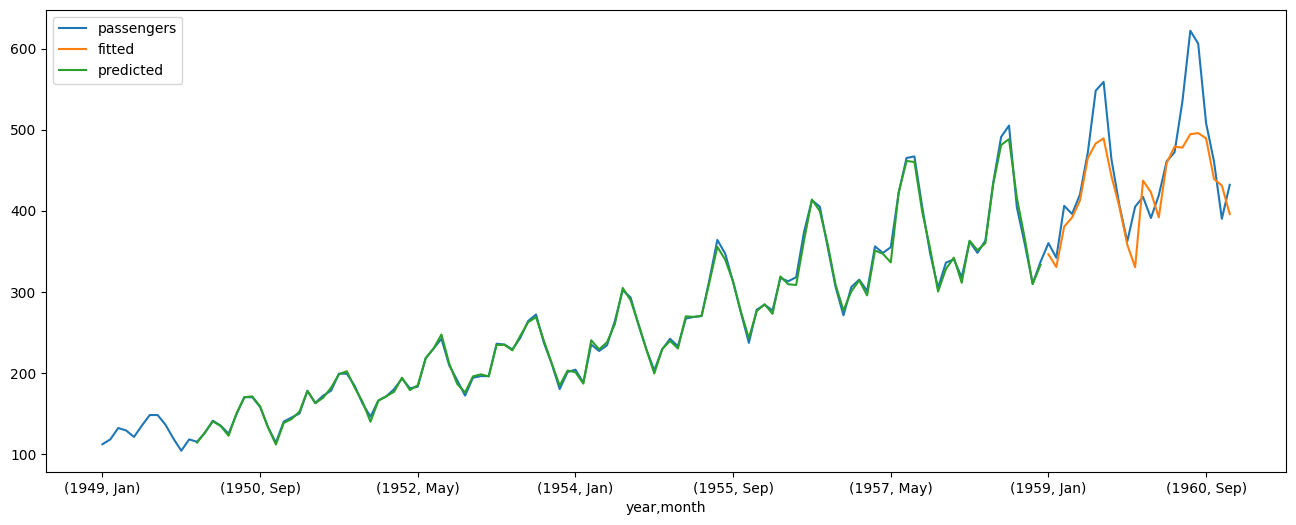

In [10]:
df_pred = df.copy()
df_pred['fitted'] = np.NaN
df_pred['predicted'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,1] = model.predict(X_test)
df_pred.iloc[WINDOW:-TEST_DATA_SIZE,2] =  model.predict(X_train)

df_pred.plot(figsize=(16,6))

## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [24]:
from waylay import WaylayClient, RestResponseError
import tempfile

waylay = WaylayClient.from_profile(PROFILE)

In [25]:
waylay.config

<WaylayConfig({"credentials": {"type": "client_credentials", "api_key": "bc8b3a2703513af3ab271a1d", "api_secret": "********", "gateway_url": "https://api.waylay.io", "accounts_url": null}, "profile": "demo", "settings": {}})>

There are many other ways to create a SavedModel, for example using [Estimators](https://www.tensorflow.org/guide/estimator#savedmodels_from_estimators) or using a custom [Module](https://www.tensorflow.org/guide/saved_model#saving_a_custom_model), all follow the same flow to upload the model to Waylay. Just pass the directory where you saved your model to the SDK and we will do the rest.

In [26]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
except RestResponseError as e:
    display(f'Ignored: {e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=DELETE;status_code=200;dur=191.011


'Removed: retries-example'

In [49]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example'
)

result

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=3576.350


{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

After upload, it can take a few seconds before the model is available for execution.

This can be seen when by inspecting the `ready` property when retrieving the model.

In [50]:
try:
    result = waylay.byoml.model.get(MODEL_NAME)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=GET;status_code=200;dur=38.523


{'createdBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'createdOn': '2023-10-16T16:13:46.996000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'updatedOn': '2023-10-16T16:13:55.235000+00:00',
 'version': '1'}

For resources such as a BYOML model, you can poll until the deployment is ready by including the `retry_until_ready` flag.

In [51]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_until_ready=True)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=GET;status_code=200;dur=34.514


{'createdBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'createdOn': '2023-10-16T16:13:46.996000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'updatedOn': '2023-10-16T16:13:55.235000+00:00',
 'version': '1'}

When making predictions, retry handling will also wait until the model is ready:

In [52]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=769.314
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=788.877


[[346.253], [330.598633], [380.376709]]

You can provide additional parameters to influence the retry behaviour:
* `retry_attempts=20`   : Maximal number of retries.
* `retry_max_delay=120` : Maximal delay in seconds.
* `timeout`             : Maximal number of seconds that the client will wait for one attempt. This parameter is available on most Python SDK calls.

In [53]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), retry_attempts=1, retry_max_delay=1)
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=8.012
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=29.115


[[346.253], [330.598633], [380.376709]]

In [54]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except Exception as e:
    display(f'{e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=DELETE;status_code=200;dur=243.519


Retry behaviour won't be triggered by non-existing resources, but only on responses with specific HTTP status codes (`409`, `429`, `500`, `502`, `503`, `504`, `508`). The _NOT FOUND_ `404` error will just be forwarded to the user:


In [62]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=404;dur=83.747


waylay.service.byoml._exceptions.ByomlActionError('operation=not_found_error')

In [71]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example',
    timeout=300
)

result

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=3749.056


{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

We immediately try prediction on the new model with a low `timeout=5` and `retry_attempts = 1`: this should fail as the endpoint will not be ready.

In [72]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), timeout=5, retry_attempts = 1)
    display(predictions[:3])
except Exception as e:
    display(e)
    


INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=4239.356
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=4258.314


[[346.253], [330.598633], [380.376709]]

Calling without extra parameters should normally wait/retry long enough for succesfull results.

In [73]:
predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
display(predictions[:3])

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=9.870
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=POST;status_code=200;dur=43.781


[[346.253], [330.598633], [380.376709]]

In [74]:
waylay.byoml.model.remove(MODEL_NAME)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=enterprise-aws;tenant=fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21;domain=demo.waylay.io;method=DELETE;status_code=200;dur=911.324


{'message': 'Model retries-example: all versions deleted',
 'name': 'retries-example',
 'versions': ['0.0.1']}